Evolution of road movement at discrete timesteps:

1. Acceleration: If the velocity $v$ of a vehicle is lower than $v_{\max}$ and if the distance to the car ahead is larger than $v+1$, increase the speed by one $[v \mapsto v+1]$


In [52]:
import numpy as np
import matplotlib.pyplot as plt
from IPython.display import display, clear_output
rng = np.random.default_rng()

In [2]:
def create_road(L):
    '''
    Set up a new, empty road
    '''
    return np.zeros(L)

In [55]:
def add_cars(L,n_cars):
    '''
    Set up a random road where a cell has nonzero velocity with probability p
    '''
    road = create_road(L)
    for i in range(n_cars):
        road[i] = 1
    road[:n_cars] = 1
    rng.shuffle(road)

    return road



In [76]:
def initial_velocities(L, n_cars, vmax, road):
    '''
    Provide initial velocities to the cars
    '''
    random_vs = rng.integers(0, high = vmax, size = L, endpoint = True)
    return np.stack((road, road*random_vs), axis = 0)


In [77]:
road_with_cars = add_cars(L = 15, n_cars = 5)
initial_road = initial_velocities(L = 15, n_cars = 5, vmax = 5, road=road_with_cars)

In [ ]:
def get_site_value(road, site_num):
    '''Return the velocity of the vehicle on site i'''

    return road[:, site_num%L]

In [ ]:
def set_site_v(road, site_num, vel, empty):
    ''' Set the velocity (if any) of the vehicle on a site'''
    if empty == False:   
        road[0, site_num%L] = 1
        road[1, site_num%L] = vel
    elif empty == True:
        road[:, site_num%L] = 0

[[ 0.  0.  0.  0.  0.  0.  1.  0.  0.  1.  0.  1.  1.  0.  1.]
 [nan nan nan nan nan nan  0. nan nan  4. nan  5.  5. nan  4.]]


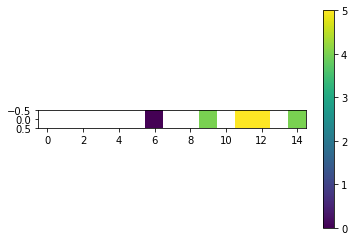

In [85]:
def plot_road(road):
    road[1, (road[0, :] == 0).astype(bool)] = np.nan
    img = plt.imshow(np.expand_dims(road[1, :], axis = 0))
    plt.colorbar()

    return img

plot_road(initial_road)


In [ ]:
def next_car_dist(road, site_num):
    '''
    Count the number of empty sites before 
    the next car (non-empty site)'''
    site_status = np.where(road[0, :])[]
    i = site_num+1
    while road[0, i]


In [95]:
site_status = np.where(initial_road[0,:] == 1)

In [96]:
site_status

(array([ 6,  9, 11, 12, 14]),)

In [94]:
initial_road

array([[ 0.,  0.,  0.,  0.,  0.,  0.,  1.,  0.,  0.,  1.,  0.,  1.,  1.,
         0.,  1.],
       [nan, nan, nan, nan, nan, nan,  0., nan, nan,  4., nan,  5.,  5.,
        nan,  4.]])